# LOADING LIBRARIES

In [2]:
! pip install monai timm

In [3]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from monai.transforms import (
    Compose, RandFlipd, RandRotate90d, RandGaussianNoised,
    RandAdjustContrastd, RandZoomd, RandGridDistortiond, RandShiftIntensityd,
    ToTensor
)

# LOADING DATASET

In [4]:
# downloading the images

!wget https://challengedata.ens.fr/media/public/train-images.zip
!wget https://challengedata.ens.fr/media/public/test-images.zip
!wget https://challengedata.ens.fr/media/public/label_Hnl61pT.csv -O y_train.csv

--2025-03-04 20:22:46--  https://challengedata.ens.fr/media/public/train-images.zip
Resolving challengedata.ens.fr (challengedata.ens.fr)... 129.199.99.148
Connecting to challengedata.ens.fr (challengedata.ens.fr)|129.199.99.148|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52391647 (50M) [application/zip]
Saving to: ‘train-images.zip’

train-images.zip    100%[===================>]  49.96M  11.9MB/s    in 4.9s    

2025-03-04 20:22:52 (10.1 MB/s) - ‘train-images.zip’ saved [52391647/52391647]

--2025-03-04 20:22:52--  https://challengedata.ens.fr/media/public/test-images.zip
Resolving challengedata.ens.fr (challengedata.ens.fr)... 129.199.99.148
Connecting to challengedata.ens.fr (challengedata.ens.fr)|129.199.99.148|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12803342 (12M) [application/zip]
Saving to: ‘test-images.zip’

test-images.zip     100%[===================>]  12.21M  7.86MB/s    in 1.6s    

2025-03-04 20:22:54 (7.86 

In [5]:
!unzip train-images.zip
!unzip test-images.zip

Archive:  train-images.zip
   creating: train-images/
  inflating: train-images/348.png    
  inflating: train-images/1804.png   
 extracting: train-images/1810.png   
 extracting: train-images/1186.png   
 extracting: train-images/412.png    
 extracting: train-images/374.png    
  inflating: train-images/1838.png   
 extracting: train-images/360.png    
 extracting: train-images/406.png    
  inflating: train-images/1192.png   
 extracting: train-images/1179.png   
 extracting: train-images/1145.png   
 extracting: train-images/1623.png   
 extracting: train-images/1637.png   
 extracting: train-images/1151.png   
 extracting: train-images/638.png    
  inflating: train-images/176.png    
 extracting: train-images/88.png     
 extracting: train-images/610.png    
 extracting: train-images/1384.png   
 extracting: train-images/1390.png   
 extracting: train-images/604.png    
  inflating: train-images/162.png    
 extracting: train-images/189.png    
 extracting: train-images/837.png 

In [6]:
def load_dataset(dataset_dir):
    dataset_list = []
    # Note: It's very important to load the images in the correct numerical order!
    for image_file in list(sorted(Path(dataset_dir).glob("*.png"), key=lambda filename: int(filename.name.rstrip(".png")))):
        dataset_list.append(cv2.imread(str(image_file), cv2.IMREAD_GRAYSCALE))
    return np.stack(dataset_list, axis=0)

# Here is a function to display side by side a slide and a segmented mask
def plot_slice_seg(slice_image, seg):
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(slice_image, cmap="gray")
    axes[1].imshow(slice_image, cmap="gray")
    seg_masked = np.ma.masked_where(seg.reshape((256,256)) == 0, (seg.reshape((256,256))))
    axes[1].imshow(seg_masked, cmap="tab20")
    plt.axis("off")
    plt.show()

In [7]:
# Read the data and keep first 800 rows
labels = pd.read_csv('y_train.csv', index_col=0).T.iloc[:800]

# Create a new DataFrame with unique values and their counts for each row
result = labels.apply(
    lambda row: pd.Series({
        'num_unique': len(row.unique())
    }),
    axis=1
)

condition = result['num_unique'].apply(lambda x: x > 1)
labels_train = labels[condition]
# Alternative en une ligne
labeled_indices_array = np.where(condition)[0]

Our dataset images shape is torch.Size([759, 1, 256, 256])
Our dataset labels shape is torch.Size([759, 256, 256])


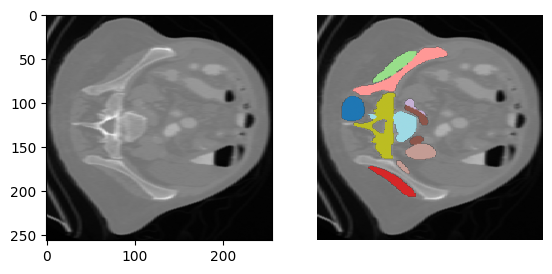

In [8]:
data_dir = Path("./")
data_train = load_dataset(data_dir / "train-images")
data_test = load_dataset(data_dir / "test-images")

## PREPROCESSING
## MIN MAX NORMALIZATION
data_train = (data_train - np.min(data_train)) / (np.max(data_train) - np.min(data_train))
data_test = (data_test - np.min(data_test)) / (np.max(data_test) - np.min(data_test))

## STANDARDIZATION
# mean, std = data_train.mean(), data_train.std()
# data_train = (data_train - mean) / (std + 1e-8)

# mean, std = data_test.mean(), data_test.std()
# data_test = (data_test - mean) / (std + 1e-8)


data_train_labeled = torch.from_numpy(data_train[labeled_indices_array]).type(torch.float32).reshape((-1, 1, 256,256))
data_test = torch.from_numpy(data_test).type(torch.float32).reshape((-1, 1, 256,256))
labels_train = torch.from_numpy(labels_train.to_numpy()).reshape((-1, 256,256))

print(f"Our dataset images shape is {data_train_labeled.shape}")
print(f"Our dataset labels shape is {labels_train.shape}")
plot_slice_seg(data_train_labeled[5].squeeze(), labels_train[5].squeeze())

In [9]:
## Split for train and test data
X_train, X_valid, y_train, y_valid = train_test_split(data_train_labeled, labels_train, test_size=0.02, random_state=0)
assert len(X_train) == len(y_train)
assert len(X_valid) == len(y_valid)
print(f"Number of training images {len(X_train)}")
print(f"Number of validation images {len(X_valid)}")

Number of training images 743
Number of validation images 16


In [10]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import random

class MyDataset(Dataset):
    def __init__(self, images, masks, augment=False):

        self.images = images
        self.masks = masks
        self.augment = augment

    def transform(self, image, mask):
        """
        Perform data augmentations manually:
        - Random Horizontal Flip
        - Random Rotation (90-degree increments)
        - Add Gaussian Noise (to the image)
        - Adjust Contrast (to the image)
        - Random Crop (only if image size is larger than target)
        """
        # Random horizontal flip
        if random.random() > 0.5:
            image = image.flip(-1)  # Flip along width (HORIZONTAL)
            mask = mask.flip(-1)

        # Random rotation (90 degrees increments)
        if random.random() > 0.5:
            k = random.randint(1, 3)  # Rotate 90, 180, or 270 degrees
            image = image.rot90(k, [1, 2])  # Rotate image
            mask = mask.rot90(k, [0, 1])  # Rotate mask

        # Add Gaussian noise to the image
        if random.random() > 0.5:
            image = self.add_gaussian_noise(image, mean=0, std=0.1)

        # Random contrast adjustment
        if random.random() > 0.5:
            image = self.adjust_contrast(image, gamma=(0.5, 2.0))

        # Random crop (only if the image size is larger than target)
        i, j, h, w = self.random_crop(image, (256, 256))
        image = image[:, i:i+h, j:j+w]
        mask = mask[i:i+h, j:j+w]

        return image, mask

    def add_gaussian_noise(self, image, mean=0, std=0.1):
        """Adds Gaussian noise to an image."""
        noise = torch.randn_like(image) * std + mean
        noisy_image = image + noise
        return torch.clamp(noisy_image, 0, 1)  # Ensure values are in range [0, 1]

    def adjust_contrast(self, image, gamma=(0.5, 2.0)):
        """Adjusts the contrast of an image."""
        gamma_value = random.uniform(gamma[0], gamma[1])
        image = image ** gamma_value
        return torch.clamp(image, 0, 1)  # Ensure values are in range [0, 1]

    def random_crop(self, image, output_size):
        """Generates random crop parameters (i, j, h, w)."""
        _, height, width = image.shape
        target_height, target_width = output_size
        i = random.randint(0, height - target_height)
        j = random.randint(0, width - target_width)
        return i, j, target_height, target_width

    def __getitem__(self, index):
        # Fetch the image and mask tensor
        image = self.images[index]
        mask = self.masks[index]

        # Apply transformation
        if self.augment:
            image, mask = self.transform(image, mask)

        return image, mask

    def __len__(self):
        return len(self.images)

from torch.utils.data import ConcatDataset


# Create the training and validation datasets
train_dataset_aug = MyDataset(X_train,y_train, augment=True)
train_dataset = MyDataset(X_train,y_train, augment=False)

valid_dataset = MyDataset(X_valid,y_valid)

final_train_dataset = ConcatDataset([train_dataset_aug, train_dataset])

# Create DataLoader for training and validation
train_loader = DataLoader(final_train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)

dir_checkpoint = Path('./')

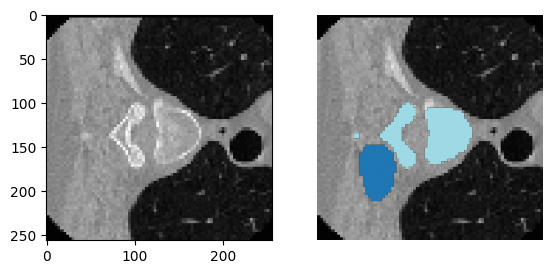

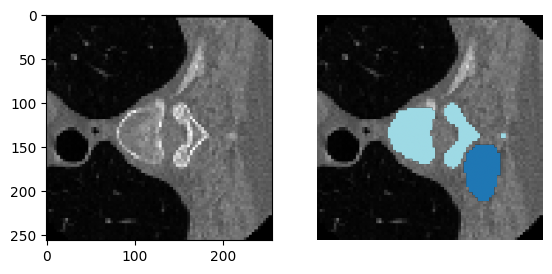

In [11]:
image, mask = train_dataset[1]  # Index 0 for the first image and its mask
aug_image, aug_mask = train_dataset_aug[1]

# Plot the image and mask
plot_slice_seg(image.squeeze(), mask)
plot_slice_seg(aug_image.squeeze(), aug_mask)

# Swin -UNET

In [12]:
## Elementary function to test UNET

def dice_image(prediction, ground_truth):
    intersection = np.sum(prediction * ground_truth)
    if np.sum(prediction) == 0 and np.sum(ground_truth) == 0:
        return np.nan
    return 2 * intersection / (np.sum(prediction) + np.sum(ground_truth))


def dice_multiclass(prediction, ground_truth):
    dices = []
    for i in range(1, NUM_CLASSES + 1): # skip background
        dices.append(dice_image(prediction == i, ground_truth == i))
    return np.array(dices)

def dice_pandas(y_true_df: pd.DataFrame, y_pred_df: pd.DataFrame) -> float:
    """Compute the dice score for each sample in the dataset and then average it"""
    y_pred_df = y_pred_df.T
    y_true_df = y_true_df.T
    individual_dice = []
    for row_index in range(y_true_df.values.shape[0]):
        dices = dice_multiclass(y_true_df.values[row_index].ravel(), y_pred_df.values[row_index].ravel())
        individual_dice.append(dices)

    final = np.stack(individual_dice)
    # First, average over images for each class
    # Then, average over classes
    cls_dices = np.nanmean(final, axis=0)
    return float(np.nanmean(cls_dices))

In [13]:
def dice_loss(pred, target, smooth=1e-7):

    pred = torch.softmax(pred, dim=1)
    target_onehot = torch.nn.functional.one_hot(target, num_classes=pred.shape[1]).permute(0, 3, 1, 2)
    intersection = (pred * target_onehot).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target_onehot.sum(dim=(2, 3))
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice.mean()

In [14]:
from tqdm import tqdm

def train_unet(model, device, train_loader, valid_loader, labels_weights, nb_epochs, save_checkpoint=True) :

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    #labels_weights = labels_weights.to(device)

    criterion = nn.CrossEntropyLoss()
    model = model.to(device)

    for epoch in tqdm(range(nb_epochs)) :

        model.train()
        train_loss = 0

        for (image, mask) in train_loader :
            image = image.to(device=device)
            mask = mask.to(device=device)
            optimizer.zero_grad()
            output = model(image)
            loss_ce = criterion(output, mask)
            loss_dice = dice_loss(output, mask)
            loss = 0.7 * loss_dice + 0.3 * loss_ce
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            # for name, param in model.named_parameters():
            #   if param.grad is not None and torch.isnan(param.grad).any():
            #       print(f"NaN gradient in {name}")
            #       return "Stooooop"

            optimizer.step()
            train_loss += loss.item()


        with torch.no_grad() :
            model.eval()
            test_loss = 0
            predictions = []
            true_masks = []

            for (image, mask) in valid_loader :

                true_masks.append(mask.cpu().numpy().squeeze())
                image = image.to(device=device)
                mask = mask.to(device=device)

                output = model(image)

                pred = torch.argmax(output, dim=1)
                predictions.append(pred.squeeze().cpu().numpy())

                loss_ce = criterion(output, mask)
                loss_dice = dice_loss(output, mask)
                loss = 0.7 * loss_dice + 0.3 * loss_ce

                test_loss += loss.item()

            predictions = pd.DataFrame(np.array(predictions).reshape((-1, 256*256)))
            valid = pd.DataFrame(np.array(true_masks).reshape((-1, 256*256)))
            score = 0

            if epoch % 10 == 0 :
              score = dice_pandas(valid, predictions)

        print(f"Epoch : {epoch} \t Training Loss : {train_loss / len(train_loader):.3f} \t Test Loss : {test_loss / len(valid_loader):.3f} \t Score: {score:.3f}")

        if save_checkpoint:
            Path(dir_checkpoint).mkdir(parents=True, exist_ok=True)
            state_dict = model.state_dict()
            torch.save(state_dict, str(dir_checkpoint / 'checkpoint_epoch{}.pth'.format(epoch)))
            #print(f'Checkpoint {epoch} saved!')

In [15]:
# import json

# # Weights for the cross entropy loss

# file_name = "./annotated_labels.json"
# with open(file_name, 'r') as file :
#     data = json.load(file)

# flattened_data = []
# for i in data :
#     flattened_data += i

# labels, labels_count = np.unique(flattened_data, return_counts=True)
# labels_weights = labels_count / np.sum(labels_count)

# # adding the background
# labels_weights = np.insert(labels_weights, 0, 0)
# class_weights = torch.from_numpy(labels_weights).type(torch.float32)
class_weighst = []

In [18]:
from monai.networks.nets import SwinUNETR

NUM_CLASSES = 55
model = SwinUNETR(img_size=(256, 256), in_channels=1,  out_channels=NUM_CLASSES,  feature_size=48, spatial_dims=2).cuda()
model.load_state_dict(torch.load(str('ckp.pth'), weights_only=True))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device : {device}")
train_unet(model, device, train_loader, valid_loader, class_weighst, nb_epochs=50, save_checkpoint=True)

Device : cuda


  0%|          | 0/50 [00:00<?, ?it/s]<ipython-input-12-fb3cb528c828>:28: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)


Epoch : 0 	 Training Loss : 0.751 	 Test Loss : 0.768 	 Score: 0.192


  2%|▏         | 1/50 [02:29<2:01:58, 149.35s/it]

Epoch : 1 	 Training Loss : 0.749 	 Test Loss : 0.757 	 Score: 0.000


  6%|▌         | 3/50 [05:42<1:25:02, 108.56s/it]

Epoch : 2 	 Training Loss : 0.748 	 Test Loss : 0.755 	 Score: 0.000
Epoch : 3 	 Training Loss : 0.748 	 Test Loss : 0.771 	 Score: 0.000


 10%|█         | 5/50 [09:00<1:16:56, 102.59s/it]

Epoch : 4 	 Training Loss : 0.747 	 Test Loss : 0.763 	 Score: 0.000


 12%|█▏        | 6/50 [10:39<1:14:23, 101.44s/it]

Epoch : 5 	 Training Loss : 0.746 	 Test Loss : 0.755 	 Score: 0.000
Epoch : 6 	 Training Loss : 0.746 	 Test Loss : 0.760 	 Score: 0.000


 14%|█▍        | 7/50 [12:18<1:12:09, 100.69s/it]

Epoch : 7 	 Training Loss : 0.745 	 Test Loss : 0.761 	 Score: 0.000


 18%|█▊        | 9/50 [15:36<1:08:13, 99.84s/it] 

Epoch : 8 	 Training Loss : 0.743 	 Test Loss : 0.762 	 Score: 0.000


 20%|██        | 10/50 [17:15<1:06:23, 99.58s/it]

Epoch : 9 	 Training Loss : 0.746 	 Test Loss : 0.761 	 Score: 0.000


<ipython-input-12-fb3cb528c828>:28: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)
 22%|██▏       | 11/50 [19:49<1:15:30, 116.18s/it]

Epoch : 10 	 Training Loss : 0.743 	 Test Loss : 0.752 	 Score: 0.210


 24%|██▍       | 12/50 [21:28<1:10:21, 111.08s/it]

Epoch : 11 	 Training Loss : 0.741 	 Test Loss : 0.772 	 Score: 0.000
Epoch : 12 	 Training Loss : 0.741 	 Test Loss : 0.747 	 Score: 0.000


 28%|██▊       | 14/50 [24:47<1:02:58, 104.97s/it]

Epoch : 13 	 Training Loss : 0.741 	 Test Loss : 0.761 	 Score: 0.000
Epoch : 14 	 Training Loss : 0.740 	 Test Loss : 0.760 	 Score: 0.000


 32%|███▏      | 16/50 [28:05<57:46, 101.95s/it]  

Epoch : 15 	 Training Loss : 0.740 	 Test Loss : 0.766 	 Score: 0.000
Epoch : 16 	 Training Loss : 0.739 	 Test Loss : 0.761 	 Score: 0.000


 36%|███▌      | 18/50 [31:23<53:35, 100.48s/it]

Epoch : 17 	 Training Loss : 0.739 	 Test Loss : 0.756 	 Score: 0.000


 38%|███▊      | 19/50 [33:02<51:41, 100.06s/it]

Epoch : 18 	 Training Loss : 0.737 	 Test Loss : 0.760 	 Score: 0.000


 40%|████      | 20/50 [34:41<49:53, 99.77s/it] 

Epoch : 19 	 Training Loss : 0.738 	 Test Loss : 0.763 	 Score: 0.000


<ipython-input-12-fb3cb528c828>:28: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)
 42%|████▏     | 21/50 [37:16<56:07, 116.13s/it]

Epoch : 20 	 Training Loss : 0.737 	 Test Loss : 0.763 	 Score: 0.203
Epoch : 21 	 Training Loss : 0.735 	 Test Loss : 0.751 	 Score: 0.000


 44%|████▍     | 22/50 [38:53<51:30, 110.38s/it]

Epoch : 22 	 Training Loss : 0.735 	 Test Loss : 0.755 	 Score: 0.000


 46%|████▌     | 23/50 [40:31<48:04, 106.82s/it]

Epoch : 23 	 Training Loss : 0.734 	 Test Loss : 0.759 	 Score: 0.000


 48%|████▊     | 24/50 [42:10<45:17, 104.51s/it]

Epoch : 24 	 Training Loss : 0.733 	 Test Loss : 0.773 	 Score: 0.000


 52%|█████▏    | 26/50 [45:29<40:42, 101.77s/it]

Epoch : 25 	 Training Loss : 0.735 	 Test Loss : 0.749 	 Score: 0.000
Epoch : 26 	 Training Loss : 0.733 	 Test Loss : 0.756 	 Score: 0.000


 56%|█████▌    | 28/50 [48:47<36:48, 100.39s/it]

Epoch : 27 	 Training Loss : 0.732 	 Test Loss : 0.762 	 Score: 0.000


 58%|█████▊    | 29/50 [50:26<34:59, 100.00s/it]

Epoch : 28 	 Training Loss : 0.735 	 Test Loss : 0.767 	 Score: 0.000
Epoch : 29 	 Training Loss : 0.732 	 Test Loss : 0.758 	 Score: 0.000


 60%|██████    | 30/50 [52:05<33:14, 99.72s/it] <ipython-input-12-fb3cb528c828>:28: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)


Epoch : 30 	 Training Loss : 0.731 	 Test Loss : 0.751 	 Score: 0.221


 62%|██████▏   | 31/50 [54:38<36:38, 115.73s/it]

Epoch : 31 	 Training Loss : 0.732 	 Test Loss : 0.767 	 Score: 0.000


 64%|██████▍   | 32/50 [56:17<33:15, 110.88s/it]

Epoch : 32 	 Training Loss : 0.730 	 Test Loss : 0.758 	 Score: 0.000


 68%|██████▊   | 34/50 [59:36<27:58, 104.90s/it]

Epoch : 33 	 Training Loss : 0.730 	 Test Loss : 0.769 	 Score: 0.000
Epoch : 34 	 Training Loss : 0.728 	 Test Loss : 0.757 	 Score: 0.000


 70%|███████   | 35/50 [1:01:15<25:46, 103.12s/it]

Epoch : 35 	 Training Loss : 0.728 	 Test Loss : 0.770 	 Score: 0.000


 72%|███████▏  | 36/50 [1:02:54<23:47, 101.94s/it]

Epoch : 36 	 Training Loss : 0.730 	 Test Loss : 0.748 	 Score: 0.000


 76%|███████▌  | 38/50 [1:06:12<20:05, 100.49s/it]

Epoch : 37 	 Training Loss : 0.728 	 Test Loss : 0.766 	 Score: 0.000
Epoch : 38 	 Training Loss : 0.727 	 Test Loss : 0.762 	 Score: 0.000


 78%|███████▊  | 39/50 [1:07:51<18:20, 100.04s/it]

Epoch : 39 	 Training Loss : 0.727 	 Test Loss : 0.761 	 Score: 0.000


 80%|████████  | 40/50 [1:09:30<16:37, 99.80s/it] <ipython-input-12-fb3cb528c828>:28: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)


Epoch : 40 	 Training Loss : 0.726 	 Test Loss : 0.761 	 Score: 0.223


 84%|████████▍ | 42/50 [1:13:45<14:50, 111.37s/it]

Epoch : 41 	 Training Loss : 0.725 	 Test Loss : 0.756 	 Score: 0.000


 86%|████████▌ | 43/50 [1:15:24<12:33, 107.71s/it]

Epoch : 42 	 Training Loss : 0.726 	 Test Loss : 0.762 	 Score: 0.000
Epoch : 43 	 Training Loss : 0.724 	 Test Loss : 0.767 	 Score: 0.000


 88%|████████▊ | 44/50 [1:17:03<10:30, 105.10s/it]

Epoch : 44 	 Training Loss : 0.724 	 Test Loss : 0.759 	 Score: 0.000


 92%|█████████▏| 46/50 [1:20:22<06:48, 102.04s/it]

Epoch : 45 	 Training Loss : 0.723 	 Test Loss : 0.769 	 Score: 0.000
Epoch : 46 	 Training Loss : 0.723 	 Test Loss : 0.768 	 Score: 0.000


 94%|█████████▍| 47/50 [1:22:01<05:03, 101.16s/it]

Epoch : 47 	 Training Loss : 0.724 	 Test Loss : 0.778 	 Score: 0.000


 96%|█████████▌| 48/50 [1:23:40<03:21, 100.52s/it]

Epoch : 48 	 Training Loss : 0.722 	 Test Loss : 0.770 	 Score: 0.000


100%|██████████| 50/50 [1:26:58<00:00, 104.37s/it]

Epoch : 49 	 Training Loss : 0.720 	 Test Loss : 0.779 	 Score: 0.000


In [23]:
from monai.networks.nets import SwinUNETR
NUM_CLASSES = 55
test_model = SwinUNETR(img_size=(256, 256), in_channels=1,  out_channels=NUM_CLASSES,  feature_size=48, spatial_dims=2).cuda()
test_model.load_state_dict(torch.load(str(dir_checkpoint / 'checkpoint_epoch49.pth'), weights_only=True))
test_model.eval()

/usr/local/lib/python3.11/dist-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)


SwinUNETR(
  (swinViT): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(1, 48, kernel_size=(2, 2), stride=(2, 2))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers1): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0-1): 2 x SwinTransformerBlock(
            (norm1): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=48, out_features=144, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=48, out_features=48, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
            (mlp): MLPBlock(
              (linear1): Linear(in_features=48, out_features=192, bias=True)
              (linear2): Linear(in_features=192,

Device : cuda


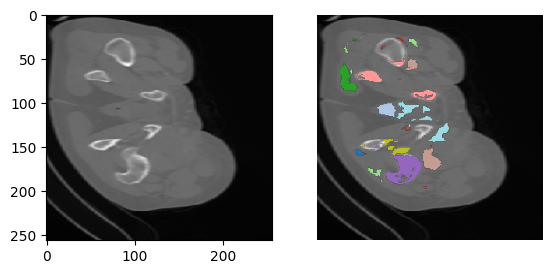

In [20]:
# VISUAL TESTING

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device : {device}")
image_test = data_test[2]
label_test = test_model(image_test.unsqueeze(0).to(device))
pred_test = torch.argmax(label_test, dim=1)
plot_slice_seg(image_test.squeeze(), pred_test.squeeze().cpu().numpy())

In [22]:
test_loader = DataLoader(data_test, batch_size=1, shuffle=False)

predictions = []

for image in test_loader :
    image = image.to(device=device)

    output = test_model(image)

    pred = torch.argmax(output, dim=1)
    predictions.append(pred.cpu().numpy())

predictions = np.array(predictions)
print(np.unique(predictions))
df = pd.DataFrame(predictions.reshape((predictions.shape[0], -1))).T

df.index = [f"Pixel {i}" for i in df.index]

df.columns = [f"{col}.png" for col in df.columns]

df.to_csv("submission.csv")

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54]


In [24]:
import torch.nn.functional as F

k = 1  # On prend les 3 classes les plus probables

valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)
true_masks = []
predictions = []

for image, mask in valid_loader:
    true_masks.extend(mask.cpu().numpy())
    image = image.to(device=device)
    mask = mask.to(device=device)

    output = test_model(image)  # Output: (batch_size, num_classes, H, W)

    # Appliquer softmax pour convertir en probabilités
    probs = F.softmax(output, dim=1)

    # Sélectionner les Top-K classes avec leurs probabilités
    topk_probs, topk_indices = torch.topk(probs, k=k, dim=1)

    # Normalisation des probabilités pour assurer une somme = 1
    topk_probs = topk_probs / topk_probs.sum(dim=1, keepdim=True)

    # Reshape to (batch_size * H * W, top_k) for multinomial
    topk_probs_reshaped = topk_probs.reshape(-1, k)

    # Perform multinomial sampling
    sampled_indices = torch.multinomial(topk_probs_reshaped, num_samples=1).squeeze(-1)

    # Reshape topk_indices to (batch_size * H * W, top_k) for gather
    topk_indices_reshaped = topk_indices.reshape(-1, k)

    # Gather from the topk_indices based on the sampled index
    pred = torch.gather(topk_indices_reshaped, -1, sampled_indices.unsqueeze(-1)).squeeze(-1)

    # Reshape back to original dimensions (batch_size, H, W)
    pred = pred.reshape(output.shape[0], output.shape[2], output.shape[3])

    predictions.extend(pred.squeeze().cpu().numpy())

predictions = pd.DataFrame(np.array(predictions).reshape((-1, 256 * 256)))
valid = pd.DataFrame(np.array(true_masks).reshape((-1, 256 * 256)))

score = dice_pandas(valid, predictions)
print(score)

0.20558577321566185


<ipython-input-12-fb3cb528c828>:28: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)
